# **Important liberary**

In [20]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [21]:
def get_data(dir,data_set):
    data = []
    train_dir = os.path.join(dir, data_set)
    for label in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(train_dir, label)
        for filename in os.listdir(folder):
            if filename.endswith(('.jpeg', '.jpg', '.png')):
                filepath = os.path.join(folder, filename)
                data.append((filepath, label))
    return pd.DataFrame(data, columns=['filepath', 'label'])


In [22]:
dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
df_train = get_data(dir,'train')
df_val = get_data(dir,'val')
df_test = get_data(dir,'test')

In [23]:
print(df_train.shape,df_test.shape,df_val.shape)

(5216, 2) (624, 2) (16, 2)


In [24]:
extra_val = df_train.groupby('label').sample(frac=0.1, random_state=42)
df_train = df_train.drop(extra_val.index)
df_val = pd.concat([df_val, extra_val])
df_val.shape


(538, 2)

# Visualization on Train Set

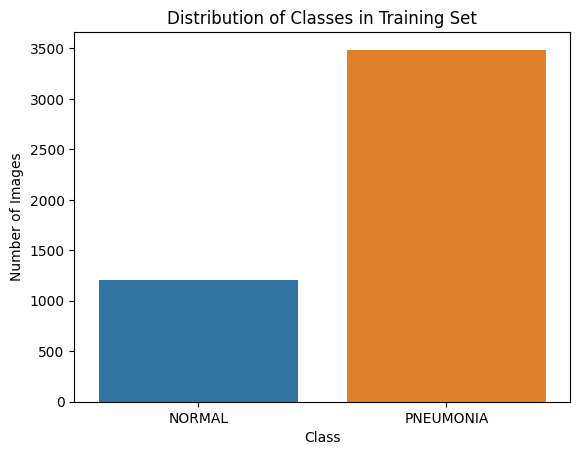

In [25]:
sns.countplot(data=df_train,x='label')

plt.title("Distribution of Classes in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

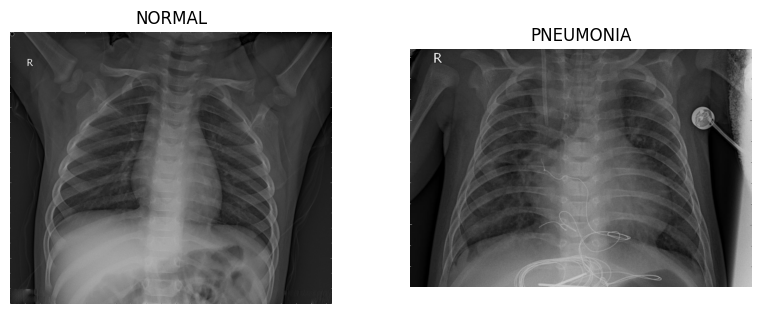

In [26]:
ind =0
plt.figure(figsize=(15,12))
for i in df_train['label'].unique():
    im =plt.imread(df_train[df_train['label']==i].iloc[0,0])
    im= cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,ind+1)
    plt.imshow(im)
    plt.title(i)
    plt.axis('off')
    ind+=1
    

# preprocessing 

In [27]:
#label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
#df_train['label'] = df_train['label'].map(label_map)
#df_val['label'] = df_val['label'].map(label_map)
#df_test['label'] = df_test['label'].map(label_map)


In [28]:
#pre on image
train_image = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_image= ImageDataGenerator(rescale=1./255)
test_image = ImageDataGenerator(rescale=1./255)

In [29]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train = train_image.flow_from_dataframe(
    dataframe=df_train ,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE ,
    batch_size=BATCH_SIZE ,
    class_mode='binary',
    shuffel=True
    
)
val = val_image.flow_from_dataframe(
    dataframe=df_val ,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE ,
    batch_size=BATCH_SIZE ,
    class_mode='binary',
    shuffel=False   
)
test = test_image.flow_from_dataframe(
    dataframe=df_test ,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE ,
    batch_size=BATCH_SIZE ,
    class_mode='binary',
    shuffel=False
    
)

Found 4694 validated image filenames belonging to 2 classes.
Found 538 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [30]:
print(df_train['label'].value_counts())

label
PNEUMONIA    3487
NORMAL       1207
Name: count, dtype: int64


# **Bulid The Model**

In [31]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [32]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [33]:
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

In [34]:
history = model.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=[early, checkpoint,reduce_lr]
)


Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.7596 - loss: 0.5532 - val_accuracy: 0.8941 - val_loss: 0.3155 - learning_rate: 0.0010
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.8591 - loss: 0.3304 - val_accuracy: 0.9052 - val_loss: 0.2333 - learning_rate: 0.0010
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.8737 - loss: 0.2842 - val_accuracy: 0.9238 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8862 - loss: 0.2665 - val_accuracy: 0.9238 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.8800 - loss: 0.2824 - val_accuracy: 0.9275 - val_loss: 0.2164 - learning_rate: 0.0010
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9145 - loss: 0.2258 - val_accuracy: 0.9331 - val_loss: 0.1875 - learning_rate: 2.0000e-04
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9136

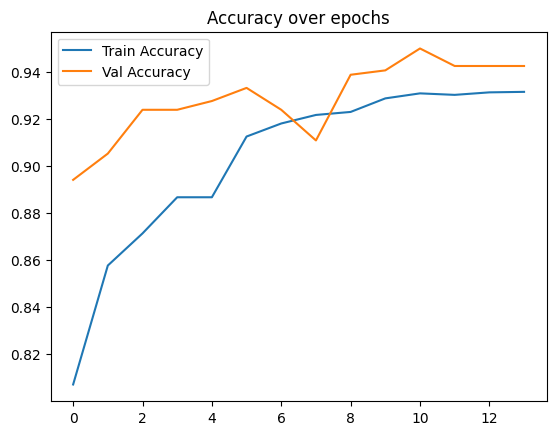

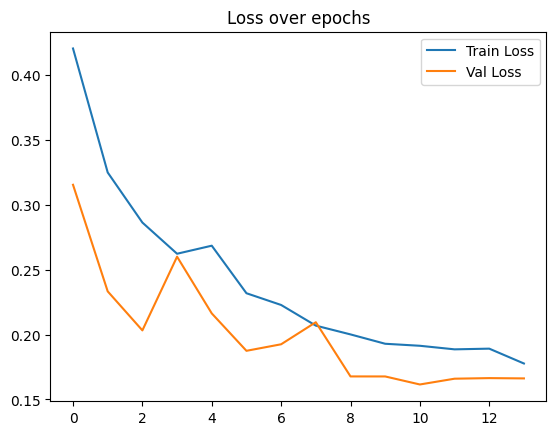

In [35]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [36]:
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 721ms/step - accuracy: 0.8813 - loss: 0.3221
Test Accuracy: 0.87
